# Using Multiscale PHATE to visualize and characterize PBMCs

## 0. Introduction

In this tutorial we will demonstrate how to use Multiscale PHATE to characterize different PBMC subsets across multiple granularities.  We will use a dataset generated by 10X from human blood for our tutorial.  We will introduce some functionalities of Multiscale PHATE, including constructing a Diffusion Condensation tree, identifying salient levels of resolution in this tree, visualizing a dataset across resolutions and zooming in to clusters of interest. We will also introduce some basics in data loading and preprocessing.

## 1. Installing and Loading packages

If you haven't already installed Multiscale PHATE, you can do so from this notebook. We will also install scprep, which is a useful package for loading and pre-processing single cell data.

In [ ]:
!pip install --user -q multiscale_phate

In [1]:
import multiscale_phate as mp
import numpy as np
import pandas as pd

import scprep
import os

## 2. Loading and filter data

In this section we will download 10X data from human PBMCs to your local computer and pre-process it for multiresolution analysis.

In [2]:
## Save data directory
data_dir = os.path.expanduser("~/multiscale_phate_data") # enter path to data directory here (this is where you want to save 10X data)
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

file_name = '10X_pbmc_data.h5'
file_path = os.path.join(data_dir, file_name)

In [3]:
URL = 'https://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc4k/pbmc4k_raw_gene_bc_matrices_h5.h5'

scprep.io.download.download_url(URL, file_path)

In [4]:
data = scprep.io.load_10X_HDF5(file_path, gene_labels='both')

data.head()

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
AAACCTGAGAAACCAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGAAACCGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGAAACCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGAAACGAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGAAACGCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that we have loaded the data, we will remove cells with low transcript counts and unexpressed genes:

/home/scottgigante/.local/lib/python3.8/site-packages/scprep/plot/histogram.py:156: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("symlog", linthreshx=abs_min)


<AxesSubplot:xlabel='Library size', ylabel='Number of cells'>

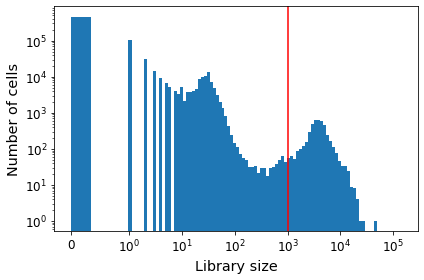

In [5]:
scprep.plot.plot_library_size(data, cutoff=1000)

In [6]:
data = scprep.filter.filter_library_size(data, cutoff=1000, keep_cells='above')
data = scprep.filter.filter_rare_genes(data)

Finally, we will library size normalize and square root transform the expression data.

In [7]:
data_norm, libsize = scprep.normalize.library_size_normalize(data, return_library_size=True)

In [8]:
data_sqrt = np.sqrt(data_norm)

data_sqrt.head()

,RP11-34P13.7 (ENSG00000238009),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),RP4-669L17.10 (ENSG00000237094),RP11-206L10.9 (ENSG00000237491),LINC00115 (ENSG00000225880),FAM41C (ENSG00000230368),NOC2L (ENSG00000188976),KLHL17 (ENSG00000187961),PLEKHN1 (ENSG00000187583),...,MT-ND6 (ENSG00000198695),MT-CYB (ENSG00000198727),BX004987.4 (ENSG00000278704),AC145212.2 (ENSG00000274847),AC011043.1 (ENSG00000276256),AL592183.1 (ENSG00000273748),AC007325.4 (ENSG00000278817),AL354822.1 (ENSG00000278384),AC004556.1 (ENSG00000276345),AC240274.1 (ENSG00000271254)
AAACCTGAGAAGGCCT-1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,4.154662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGACAGACC-1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,6.573422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGATAGTCA-1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,6.449217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGCGCCTCA-1,0.0,0.0,0.0,0.0,2.077481,0.0,0.0,2.077481,0.0,0.0,...,0.0,5.876003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGGCATGGT-1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,3.661874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Creating multi-resolution embeddings and clusters with Multiscale PHATE

Computing Multiscale PHATE tree involves three successive steps:

1. Building you Multiscale PHATE operator
2. Fitting your data with your operator to construct a diffusion condensation tree and identify salient resolutions for clustering and visualization
3. Embedding and clustering your data at selected resolutions


In [9]:
mp_op = mp.Multiscale_PHATE()

levels = mp_op.fit(data_sqrt)

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 6.50 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 27.40 seconds.
  Setting epsilon to 3.6139
  Setting merge threshold to 0.2198
  Calculating condensation...
  Calculated condensation in 5.10 seconds.
Calculated Multiscale PHATE tree in 39.28 seconds.
Computing gradient...
Identifying salient levels of resolution...


In order to identify salient levels of the diffusion condensation tree, we can visualize the output of our gradient analysis:

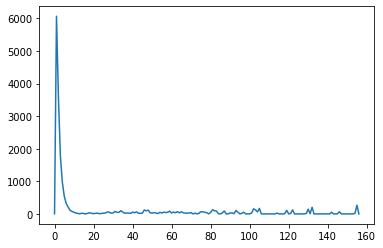

In [10]:
import matplotlib.pyplot as plt
plt.plot(mp_op.gradient)

In [11]:
levels

[0, 13, 16, 71, 73, 88, 99, 112, 116, 127, 140, 144, 153]

To produce a coarse initial embedding of the dataset, we select a level of resolution for our clusters (the 10th salient resolution identified) and a finer level of resoultion for our embedding (the 4th salient resolution identified).

In [12]:
coarse_embedding, coarse_clusters, coarse_sizes = mp_op.transform(levels[4], levels[10])

<AxesSubplot:xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

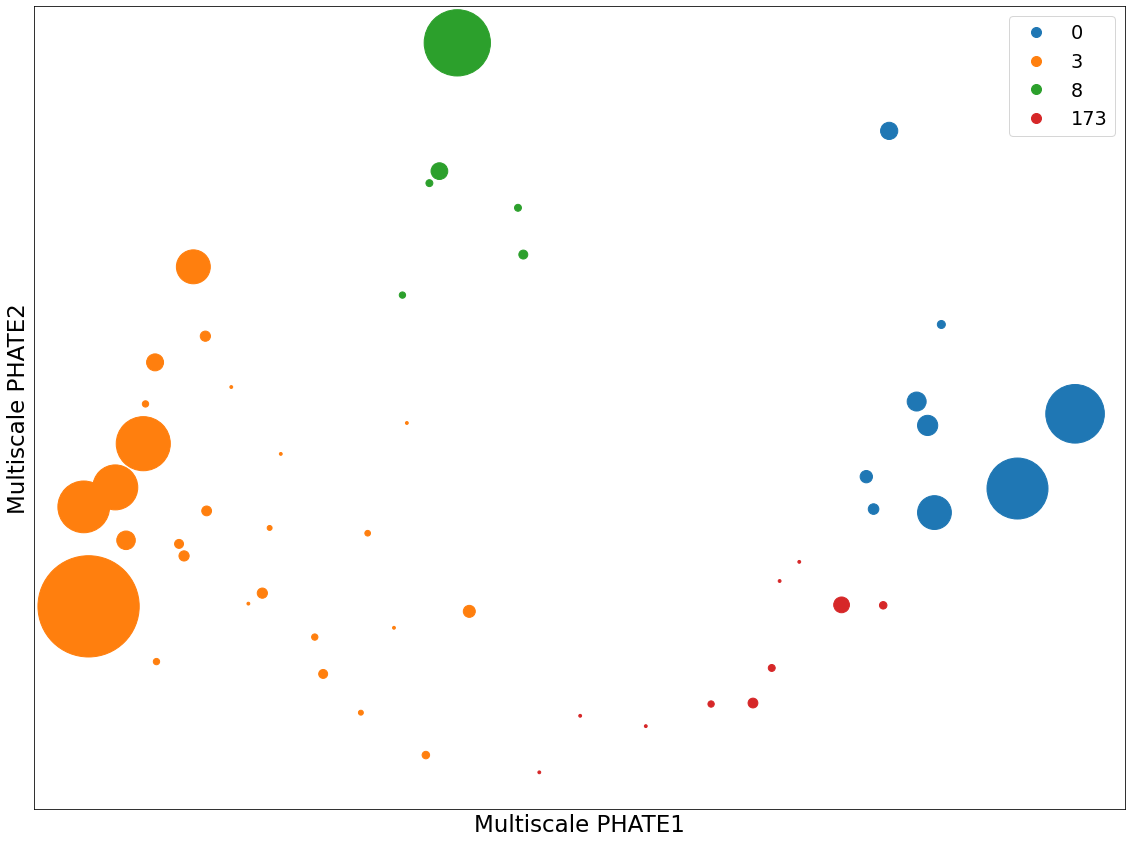

In [13]:
scprep.plot.scatter2d(coarse_embedding, s = 8*coarse_sizes, c = coarse_clusters,
                      fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(16,12))

By modifying the ideal resolutions passed to the .transform() function, we can modify the granularity of the visualization and the clusters, producing coarser or finer embeddings and groupings of the data.

<AxesSubplot:xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

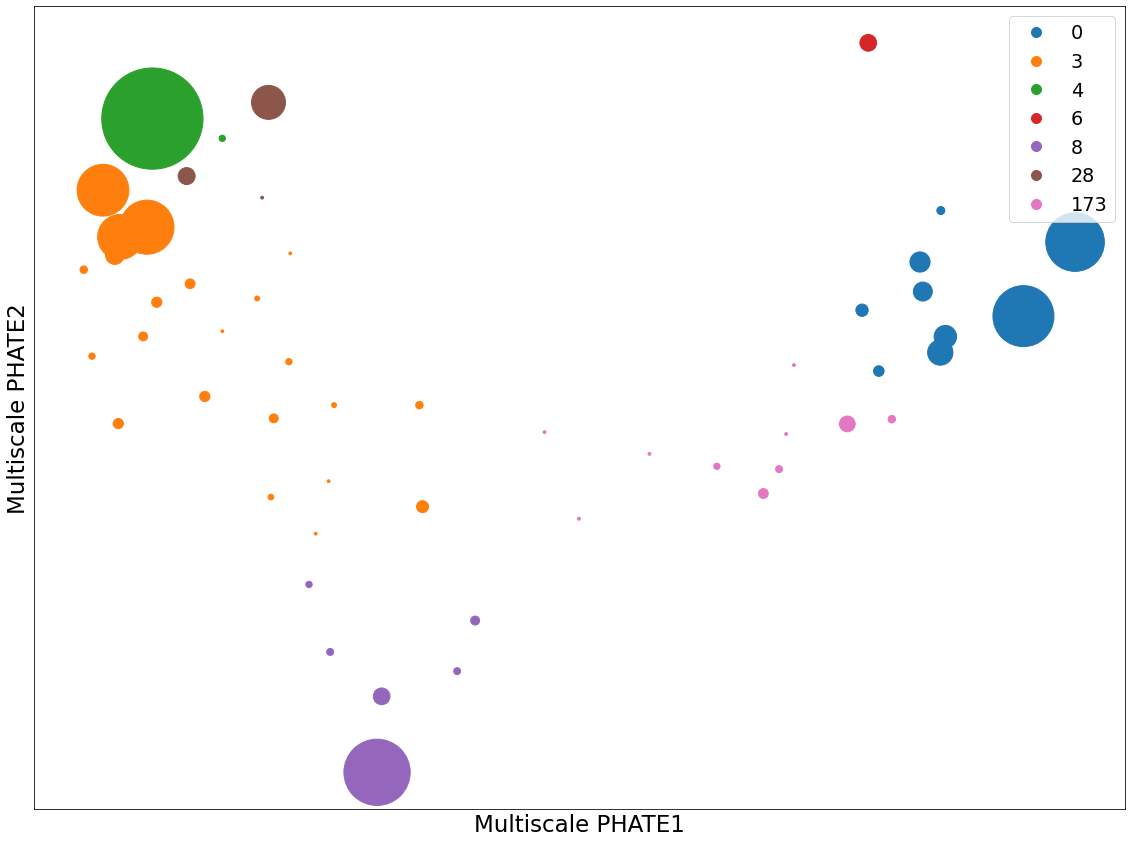

In [14]:
fine_embedding, fine_clusters, fine_sizes = mp_op.transform(levels[3], levels[9])

scprep.plot.scatter2d(fine_embedding, s = 8*fine_sizes, c = fine_clusters,
                      fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(16,12))

Using .transform() we can also fulfill Multiscale PHATE's 'zoom in' capability. By passing the function:
1. A new 'zoom in' visualization granularity
2. A new 'zoom in' clustering granularity
3. A previous resolution of coarse clusters
4. A cluster in the coarse clusters to 'zoom in' on

These variables allow for a detailed visualization and subclustering on a population of interest.

In [15]:
zoom_embedding, zoom_clusters, zoom_sizes =  mp_op.transform(levels[1], levels[6], levels[9], 8)

<AxesSubplot:xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

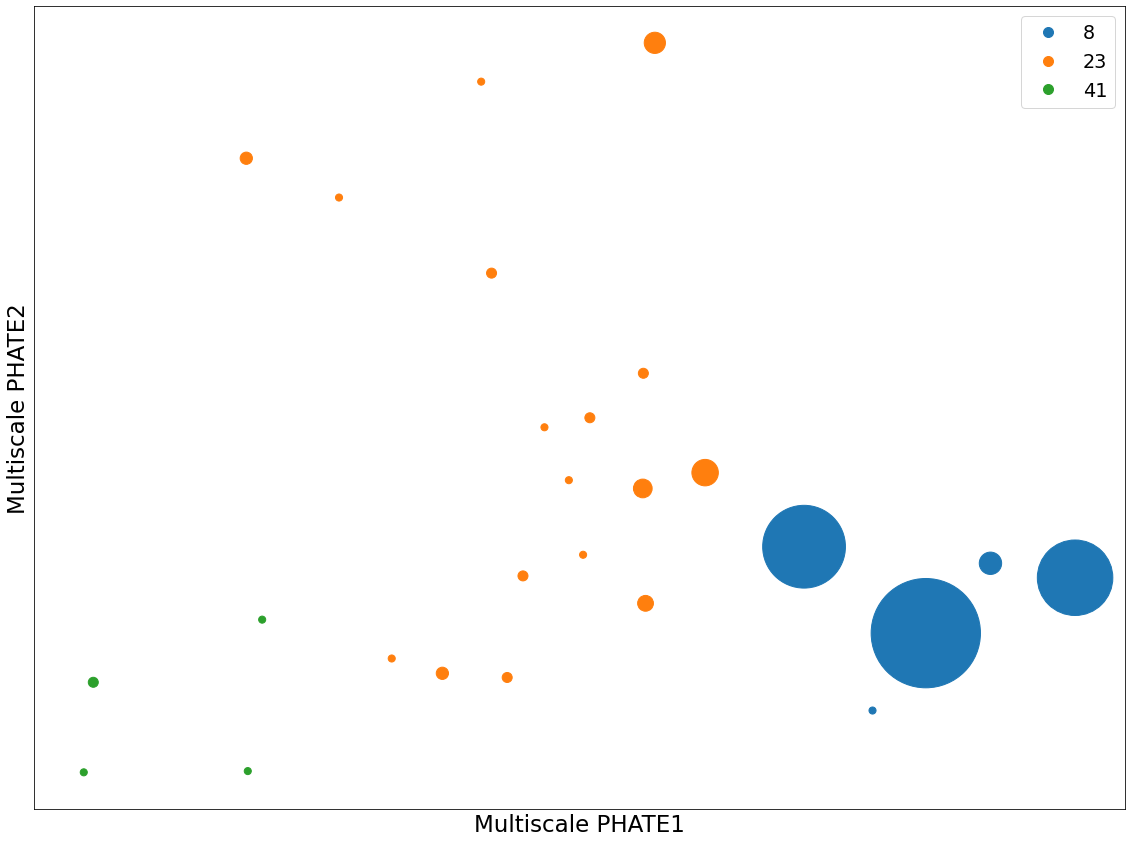

In [16]:
scprep.plot.scatter2d(zoom_embedding, s = 50*zoom_sizes, c = zoom_clusters,
                      fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(16,12))

## 4. Visualizing full Diffusion Condensation tree

As Diffusion Condensation creates a hierarchy of cells and clusters, it can be useful to visualize this tree. We can do this with he build_tree() function:

Calculating base visualization...
Calculated base visualization in 6.38 seconds.
Calculating tree...
Calculated tree in 0.21 seconds.


<Axes3DSubplot:>

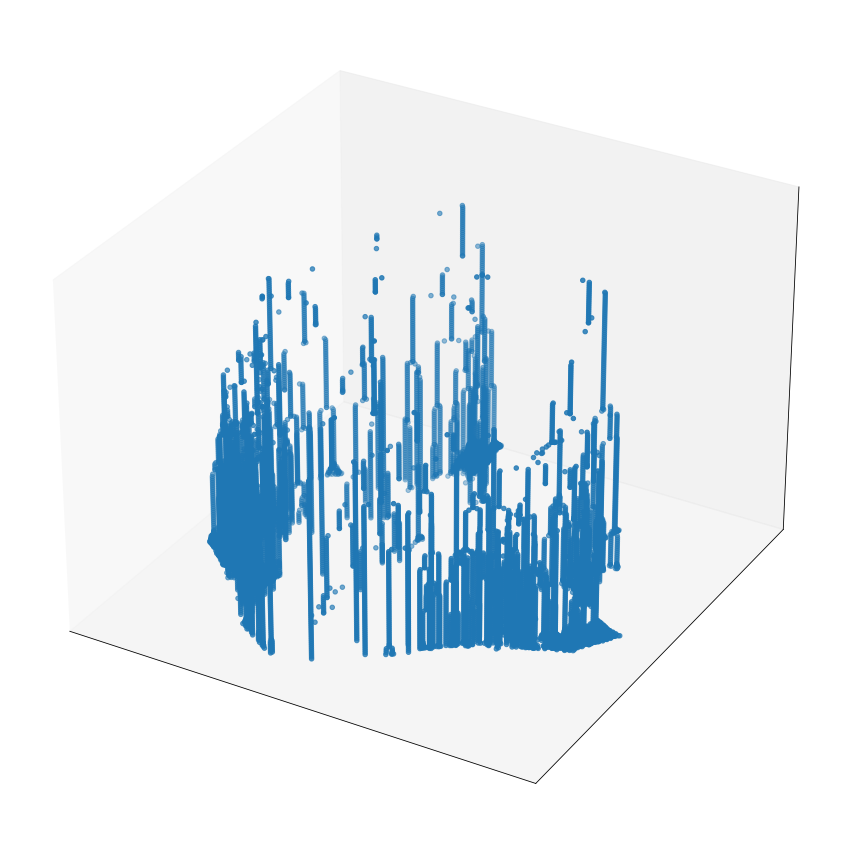

In [17]:
### building tree

tree = mp_op.build_tree()

scprep.plot.scatter3d(tree, s= 20,
                      fontsize=16, ticks=False, figsize=(16,12))

It can also be useful to color the tree with various labels, such as diffusion condensation iteration and by a particular layer of the tree. Since the tree is effectively a series of stacked 2D condensed points, coloring the tree by the third column will color each point by its corresponding iteration:

/home/scottgigante/.local/lib/python3.8/site-packages/scprep/plot/tools.py:247: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mappable = plot_axis.imshow(


<Axes3DSubplot:>

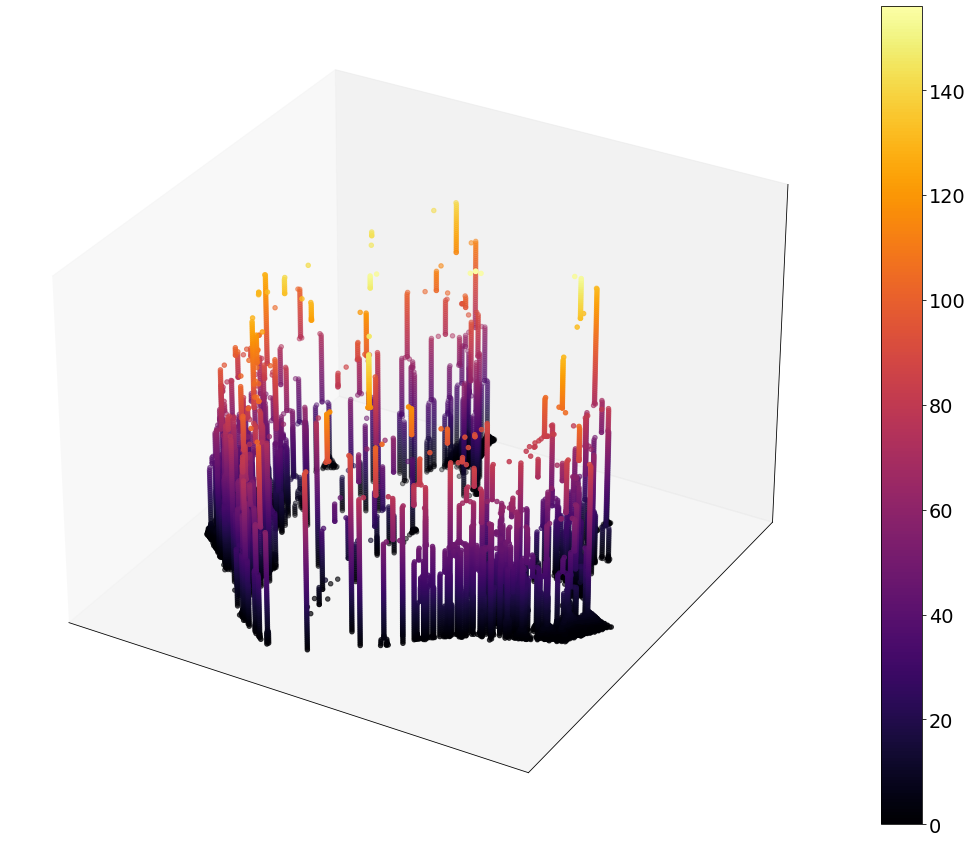

In [18]:
scprep.plot.scatter3d(tree, c = tree[:,2], s= 20,
                      fontsize=16, ticks=False, figsize=(16,12))

In order to color the tree by clusters found at a paticular granularity of the Diffusion Condensation tree, we simply pass a resolution to the .get_tree_clusters() function.

<Axes3DSubplot:>

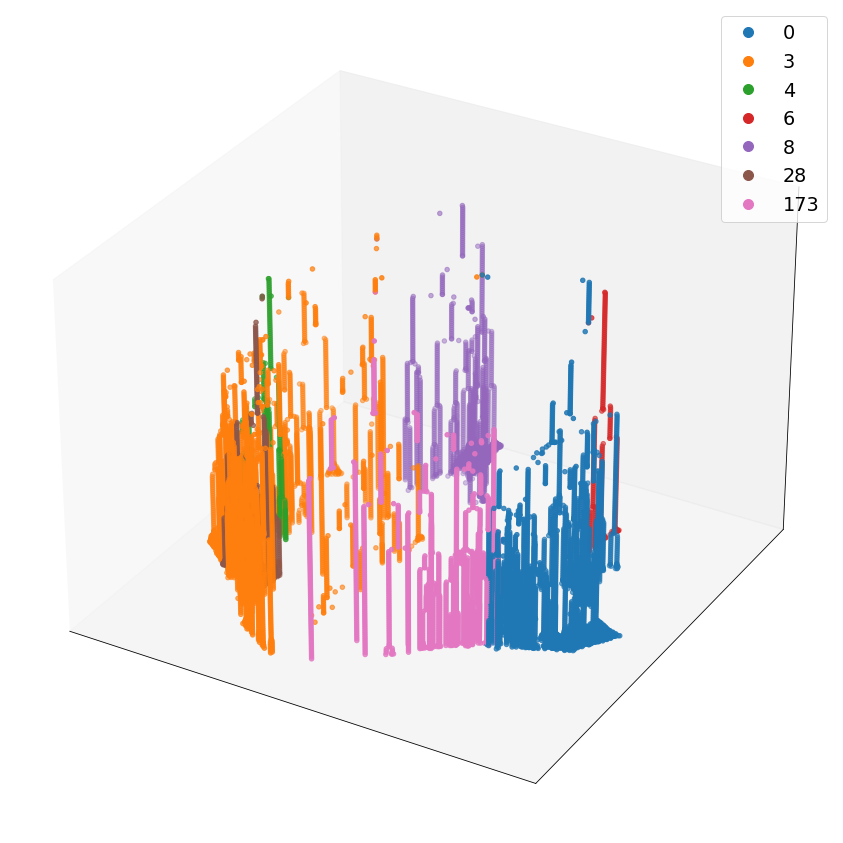

In [19]:
tree_clusters = mp_op.get_tree_clusters(levels[9])

scprep.plot.scatter3d(tree, c = tree_clusters, s= 20,
                      fontsize=16, ticks=False, figsize=(16,12))

## 5. Conclusion

Multiscale PHATE is a novel multi-resolution machine learning tool that is able to analyze big datasets across multiple granularities. With our approach we are able to construct a hierarchy of cluster similarities which we use to zoom in and out of regions of interest. Finally, we are able to visualize this hierarchy to see how these clusters merge together over time.